In [2]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import random

print("TensorFlow version: ",tf.__version__)

2025-02-07 23:43:33.460153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-07 23:43:33.460191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-07 23:43:33.461420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 23:43:33.467161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version:  2.15.0


In [3]:
EPS = 2./255
IMAGENET_LABELS = "./data/imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

In [27]:
k = 4
secret_labels = random.sample(range(1000), k)
print("Secret labels:", secret_labels)
print("Secret label names:", [IMAGENET_CLASSES[label] for label in secret_labels])

Secret labels: [950, 177, 363, 183]
Secret label names: ['orange', 'Scottish_deerhound', 'armadillo', 'Kerry_blue_terrier']


In [28]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels, preprocess=False):
    if preprocess:
        image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

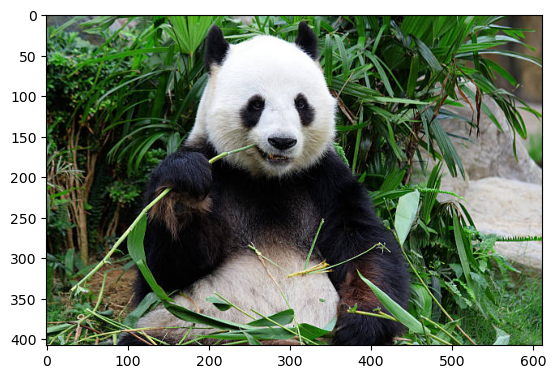

In [29]:
sample_image = show_image("./data/imagenet/giant_panda/giantpanda.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

In [30]:
preds = resnet50.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

1/1 [==============================] - 1s 658ms/step
Predicted: [('n02510455', 'giant_panda', 0.9987178), ('n02509815', 'lesser_panda', 0.00057549786), ('n02488702', 'colobus', 0.00029330383)]
Class idx: 388


In [39]:
def generate_adversaries_targeted(image_tensor, delta, model, true_index, target_indices, optimizer):
    """
    Generate adversarial perturbations to embed the watermark.
    
    Args:
        image_tensor (tf.Tensor): Input image tensor.
        delta (tf.Variable): Perturbation tensor.
        model (tf.keras.Model): Pre-trained ImageNet model.
        true_index (int): Index of the true class (e.g., panda).
        target_indices (list): Indices of the target classes (secret labels).
        optimizer (tf.keras.optimizers.Optimizer): Optimizer for training.
    
    Returns:
        tf.Tensor: Final perturbation tensor.
    """
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    for t in range(350):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            
            # Ensure the primary classification remains dominant
            true_loss = scc_loss(tf.convert_to_tensor([true_index]), predictions)
            
            # Encourage the model to increase logits for the target labels
            target_loss = 0
            for label in target_indices:
                target_loss += scc_loss(tf.convert_to_tensor([label]), predictions)
            
            # Combine the losses with appropriate weights
            loss = true_loss + target_loss  # Adjust the weight (0.1) as needed
            
            if t % 20 == 0:
                print(f"Iteration {t}, Loss: {loss.numpy()}")
        
        # Get gradients and update delta
        gradients = tape.gradient(loss, delta)
        optimizer.apply_gradients([(gradients, delta)])
        
        # Clip delta to ensure perturbations are small
        delta.assign_add(clip_eps(delta))
    
    return delta

def perturb_image(image_path, true_label, target_labels, model, optimizer):
    """
    Perturb an image to embed a watermark and verify the watermark.
    
    Args:
        image_path (str): Path to the input image.
        true_label (int): Index of the true class (e.g., panda).
        target_labels (list): Indices of the target classes (secret labels).
        model (tf.keras.Model): Pre-trained ImageNet model.
        optimizer (tf.keras.optimizers.Optimizer): Optimizer for training.
    """
    # Load and preprocess image
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocess_input(preprocessed_image))
    print(unsafe_preds)
    unsafe_probs = tf.nn.softmax(unsafe_preds).numpy()  # Apply softmax
    print("Prediction before adv.:", decode_predictions(unsafe_probs, top=3)[0])

    # Initialize the perturbation tensor
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, true_label, target_labels, optimizer)
    plt.imshow(50 * delta_tensor.numpy().squeeze() + 0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze() / 255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = model.predict(perturbed_image)
    print(preds)
    probs = tf.nn.softmax(preds).numpy()  # Apply softmax
    print("Prediction after adv.:", decode_predictions(probs, top=10)[0])

    # Verify the watermark
    if verify_watermark(probs, target_labels, threshold=0.000000001):
        print("Watermark verified!")
    else:
        print("Watermark NOT verified.")

def verify_watermark(probs, target_labels, threshold=0.1):
    """
    Verify the watermark by checking if the probabilities of the target labels exceed a threshold.
    
    Args:
        probs (numpy.ndarray): Probabilities output by the model (shape: [1, 1000]).
        target_labels (list): Indices of the target classes (secret labels).
        threshold (float): Threshold for watermark verification.
    
    Returns:
        bool: True if the watermark is verified, False otherwise.
    """
    for label in target_labels:
        if probs[0, label] < threshold:
            return False  # At least one target label does not exceed the threshold
    return True  # All target labels exceed the threshold

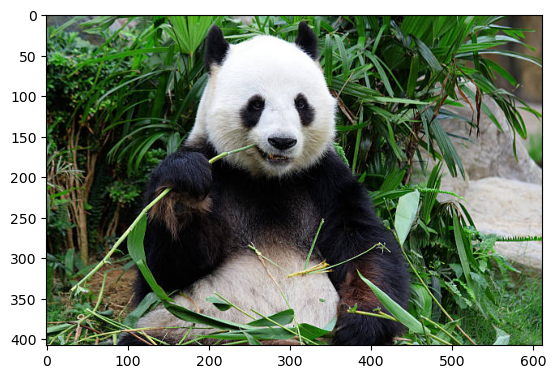

1/1 [==============================] - 0s 19ms/step
[[6.15495708e-08 1.47184034e-08 2.56788657e-09 3.34709904e-09
  1.22398347e-09 1.27629540e-09 1.71395464e-09 5.26690371e-08
  2.05866712e-07 8.47654391e-09 1.62910030e-09 4.76520832e-08
  9.72188552e-10 8.60388916e-09 6.60934996e-09 2.35596231e-09
  9.72020331e-09 1.50990516e-07 2.46278830e-07 4.81827165e-08
  5.48841239e-09 2.13011802e-07 5.96668102e-08 3.02233434e-06
  1.84715191e-07 2.65326996e-08 2.56723487e-09 2.71913336e-09
  3.76914189e-09 1.54660267e-08 2.22776109e-09 1.38713023e-08
  4.78497864e-09 1.55490252e-08 6.10176976e-09 5.19695798e-09
  3.80991139e-07 5.99399730e-09 1.05760589e-09 1.52337449e-08
  2.90989099e-09 1.28542510e-09 1.55094533e-08 8.10377010e-09
  7.37130756e-09 3.70443431e-09 6.86697588e-09 4.45468329e-09
  5.17365031e-08 2.18160459e-08 4.10443368e-09 9.68973950e-08
  1.26370976e-08 1.40196441e-08 1.86009466e-08 1.12831193e-08
  4.76848143e-08 2.41066545e-08 2.82085928e-08 8.29501179e-09
  8.22606427e-09 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


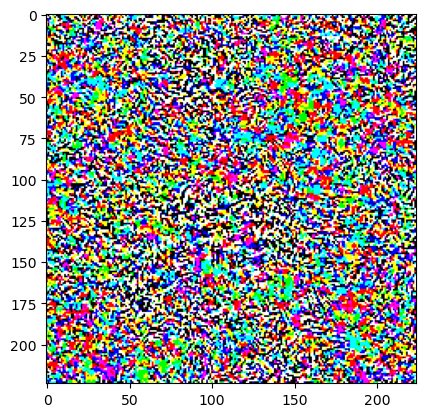

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


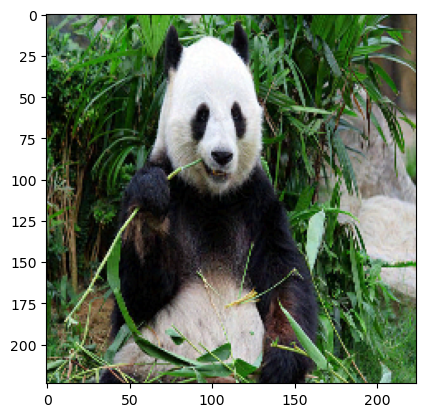

1/1 [==============================] - 0s 19ms/step
[[9.24823515e-04 2.11390783e-04 5.57405183e-05 1.29369975e-04
  4.11941692e-05 3.34758079e-05 4.22523008e-05 1.13370956e-03
  1.14172092e-03 3.05167021e-04 6.36869663e-05 4.57476941e-04
  1.05285588e-04 1.58164650e-04 1.13129114e-04 2.47377495e-04
  2.80839246e-04 1.47727481e-03 1.21508364e-03 2.87337141e-04
  2.54278595e-04 1.27274683e-03 8.14991945e-04 7.89367035e-03
  1.16322085e-03 5.35020954e-04 1.38161675e-04 7.73224601e-05
  1.07723325e-04 3.50251794e-04 1.47797080e-04 1.05663996e-04
  9.97132956e-05 2.95847974e-04 2.84763693e-04 2.04200333e-04
  3.17336456e-03 3.22394131e-04 7.14010603e-05 5.42056863e-04
  1.07474181e-04 1.30175846e-04 2.09672638e-04 2.25699492e-04
  2.22362927e-04 1.56000649e-04 3.30919080e-04 2.12155122e-04
  4.13962814e-04 4.47747792e-04 2.32181294e-04 9.04184824e-04
  4.18465992e-04 1.00400613e-03 7.49914034e-04 8.05040007e-04
  4.71890118e-04 9.56688076e-04 1.01869274e-03 2.93807825e-04
  3.83257226e-04 6

In [40]:
#@title Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
perturb_image("./examples/panda.jpg", 388, secret_labels, resnet50, optimizer)